# ChoGAN: Generative Adversarial Networks Inspired by Frédéric Chopin
## Corinne Dickey

<br> 

Load external packages:

In [2]:
import numpy as np
import pandas as pd
import os
from tensorflow.python.framework import ops
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

from storage.utils import collect_midi_data, song_metrics, plot_dists, \
    extract_notes, get_distinct, create_lookups, prepare_sequences, \
    get_input_outputs, create_note_embeddings, create_lstm_network, \
    create_gru_network, create_gru_lstm_network, train_network, plot_loss, \
    evaluate_loss, generate_notes, store_generated_midi

Import data:

In [3]:
midi_data = collect_midi_data('storage/data')

Imported 44 files.


## Exploratory Analysis

In [4]:
midi_data.head()

,file,midi,tempo,n_seconds,n_minutes
0,storage/data/chpn-p19.mid,<pretty_midi.pretty_midi.PrettyMIDI object at ...,243.613,67,1.07
1,storage/data/chpn_op25_e2.mid,<pretty_midi.pretty_midi.PrettyMIDI object at ...,165.155,98,1.38
2,storage/data/chpn-p15.mid,<pretty_midi.pretty_midi.PrettyMIDI object at ...,165.611,274,4.34
3,storage/data/chpn_op35_4.mid,<pretty_midi.pretty_midi.PrettyMIDI object at ...,167.062,83,1.23
4,storage/data/chpn-p11.mid,<pretty_midi.pretty_midi.PrettyMIDI object at ...,178.155,30,0.30


In [5]:
song_metrics(midi_data)

Number of songs: 44
Total hours of music: 1.8
Average song duration (in minutes): 2.3


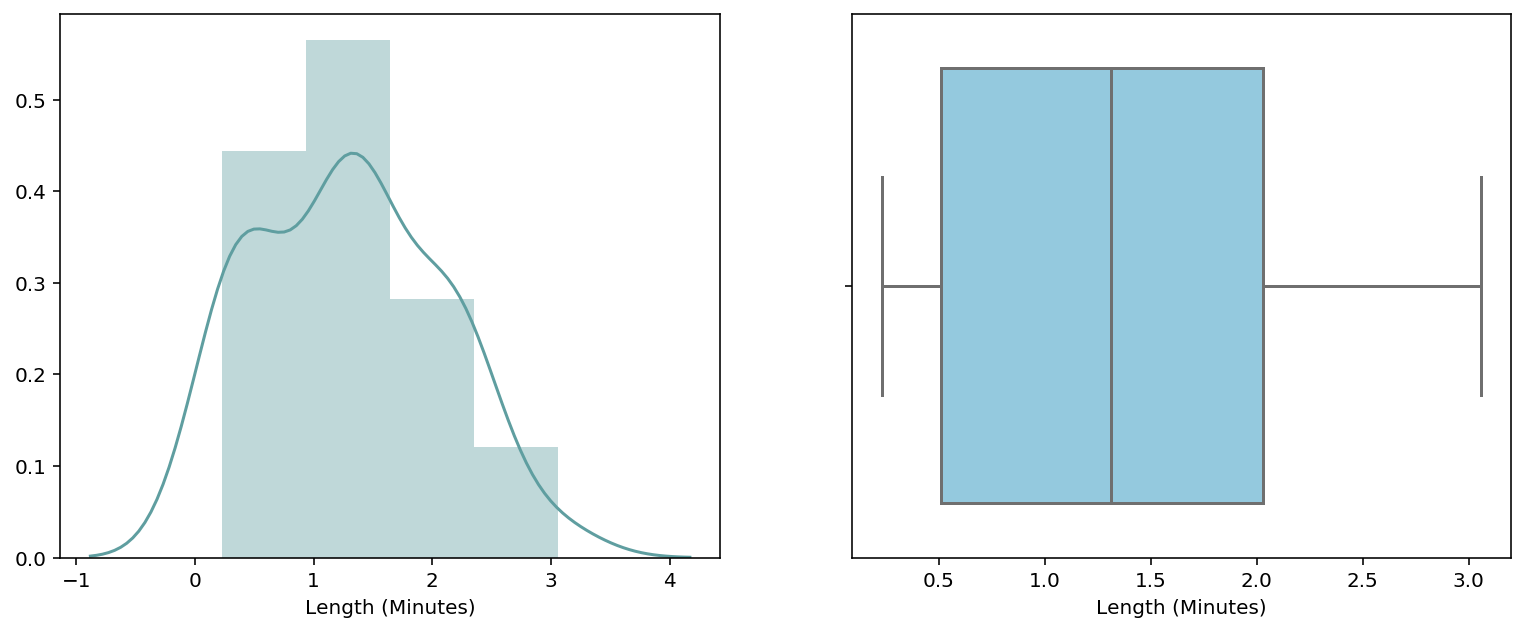

In [6]:
plot_dists(midi_data[midi_data['n_minutes'] < 4]['n_minutes'], title='Length (Minutes)')

## Data Preparation

Gather notes and durations:

In [7]:
music_data = midi_data[midi_data['n_minutes'] < 4][['file', 'n_seconds', 'n_minutes']].reset_index(drop=True)
music_data['set'] = None
music_data.loc[0:round(len(music_data)*.9)-1, 'set'] = 'train'
music_data['set'] = music_data['set'].fillna('test')
music_data['notes'] = None
music_data['durations'] = None

music_data = extract_notes(music_data)

Prepare sequences:

In [8]:
music_data['padded_notes'] = music_data['notes'].apply(lambda x : ['sos'] + x)
music_data['padded_durations'] = music_data['durations'].apply(lambda x : [0] + x)

notes = list(np.concatenate(music_data.padded_notes))
durations = list(np.concatenate(music_data.padded_durations))

# Get the distinct sets of notes and durations
note_names, n_notes = get_distinct(notes)
duration_names, n_durations = get_distinct(durations)
distincts = [note_names, n_notes, duration_names, n_durations]
    
# Get the lookup dictionaries for notes and dictionaries and save
note_to_int, int_to_note = create_lookups(note_names)
duration_to_int, int_to_duration = create_lookups(duration_names)
lookups = [note_to_int, int_to_note, duration_to_int, int_to_duration]

In [9]:
print('Number of unique notes:', n_notes)
print('Number of unique durations:', n_durations)

Number of unique notes: 2660
Number of unique durations: 24


Collect train/test sets of 4 and 12 sequences:

In [10]:
# Train 
train_data_ref = music_data[music_data['set'] == 'train'].reset_index(drop=True)
train_input_4, train_output_4 = get_input_outputs(train_data_ref, lookups, distincts, seq_len=4)
train_input_12, train_output_12 = get_input_outputs(train_data_ref, lookups, distincts, seq_len=12)

# Test
test_data_ref = music_data[music_data['set'] == 'test'].reset_index(drop=True)
test_input_4, test_output_4 = get_input_outputs(test_data_ref, lookups, distincts, seq_len=4)
test_input_12, test_output_12 = get_input_outputs(test_data_ref, lookups, distincts, seq_len=12)

# Combine Sets
seq_set_4 = [train_input_4, train_output_4] + [test_input_4, test_output_4]
seq_set_12 = [train_input_12, train_output_12] + [test_input_12, test_output_12]

# Print sample inputs/outputs 
print('\n4 note sequence input:')
print(train_input_4[0][1])
print('\n4 duration sequence input:')
print(train_input_4[1][1])
print('\n4 note sequence output:')
print(train_output_4[0][1])
print('\n4 duration sequence output:')
print(train_output_4[1][1])


4 note sequence input:
[0.99962406 0.99962406 0.99962406 0.13947368]

4 duration sequence input:
[0.         0.         0.         0.41666667]

4 note sequence output:
[0. 0. 0. ... 0. 0. 0.]

4 duration sequence output:
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


<br>

Create note embeddings:

In [11]:
key_note_emb = create_note_embeddings(notes, note_names)

Note embedding dimensions: (2660, 81)


In [12]:
print('\nSample embedding for A1.B-1:')
key_note_emb[1]


Sample embedding for A1.B-1:


array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00225564,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

<br> 

## Model Development




| -                  | 4 Sequences            | 12 Sequences           |
|:--------------------|------------------------|------------------------|
| __LSTM__           | Experiment 1           | Experiment 2           |
| __GRU__            | Experiment 3           | Experiment 4           |
| __GRU with LSTM__  | Experiment 5           | Experiment 6           |


Define note generator parameters:

In [13]:
notes_temp=.2
duration_temp =.2
max_extra_notes = 32
max_seq_len =32
seq_len = 32

<br> 

#### Experiment 1: LSTM and 4 Sequences

Training over 84 epochs.

84 epochs completed in 120.0 seconds.



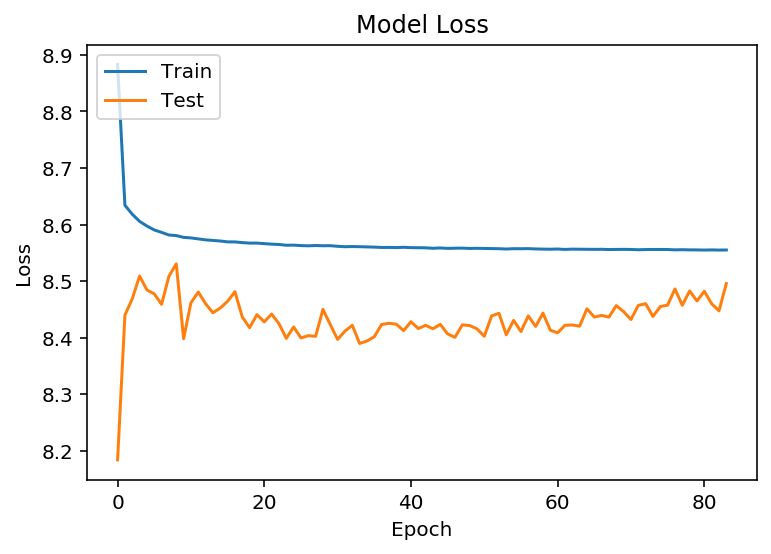

In [15]:
# Train
ops.reset_default_graph()
model_exp_1, attn_exp_1 = create_lstm_network(n_notes, n_durations, key_note_emb)
exp_1 = train_network(model_exp_1, 'exp_1', seq_set_4)
plot_loss(exp_1)

In [16]:
# Evaluate
model_exp_1.load_weights('storage/experiments/exp_1/weights.h5')
exp_1_loss = evaluate_loss(model_exp_1, 'exp_1', seq_set_4)
exp_1_loss

1668/1668 [==============================] - 0s 164us/sample - loss: 8.4473 - pitch_loss: 7.3306 - duration_loss: 1.1265


,Set,Loss,Pitch Loss,Duration Loss
0,Train,8.5552,6.9606,1.5945
1,Test,8.4473,7.3306,1.1265


In [17]:
# Generate
exp_1_output = generate_notes(model_exp_1, attn_exp_1, 
                              notes_temp, duration_temp, max_extra_notes, max_seq_len, seq_len, 
                              note_to_int, int_to_note, duration_to_int, int_to_duration)

store_generated_midi(exp_1_output, 'exp_1')

Generated sequence of 64 notes


<br> 

#### Experiment 2: LSTM and 12 Sequences

Training over 84 epochs.

84 epochs completed in 196.0 seconds.



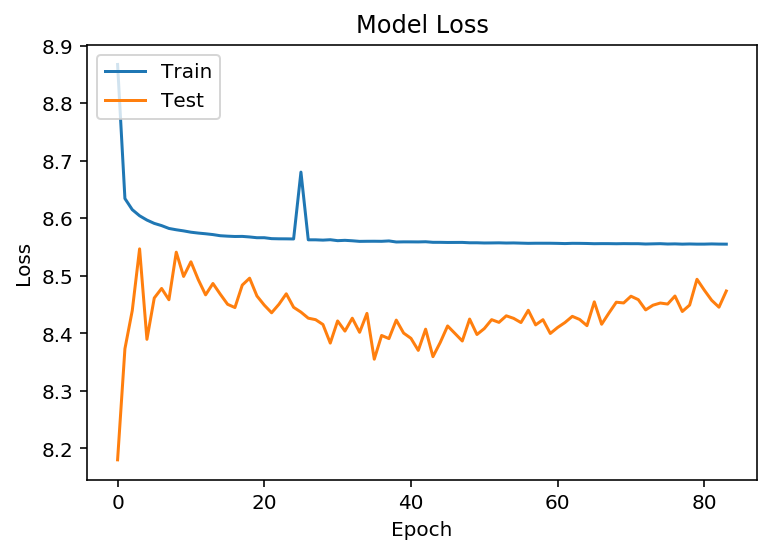

In [19]:
# Train
ops.reset_default_graph()
model_exp_2, attn_exp_2 = create_lstm_network(n_notes, n_durations, key_note_emb)
exp_2 = train_network(model_exp_2, 'exp_2', seq_set_12)
plot_loss(exp_2)

In [20]:
# Evaluate
model_exp_2.load_weights('storage/experiments/exp_2/weights.h5')
exp_2_loss = evaluate_loss(model_exp_2, 'exp_2', seq_set_12)
exp_2_loss

1668/1668 [==============================] - 0s 279us/sample - loss: 8.4736 - pitch_loss: 7.3176 - duration_loss: 1.1651


,Set,Loss,Pitch Loss,Duration Loss
0,Train,8.5508,6.9560,1.5947
1,Test,8.4736,7.3176,1.1651


In [21]:
# Generate
exp_2_output = generate_notes(model_exp_2, attn_exp_2, 
                              notes_temp, duration_temp, max_extra_notes, max_seq_len, seq_len, 
                              note_to_int, int_to_note, duration_to_int, int_to_duration)

store_generated_midi(exp_2_output, 'exp_2')

Generated sequence of 64 notes


<br> 

#### Experiment 3: GRU and 4 Sequences

Training over 84 epochs.

84 epochs completed in 136.0 seconds.



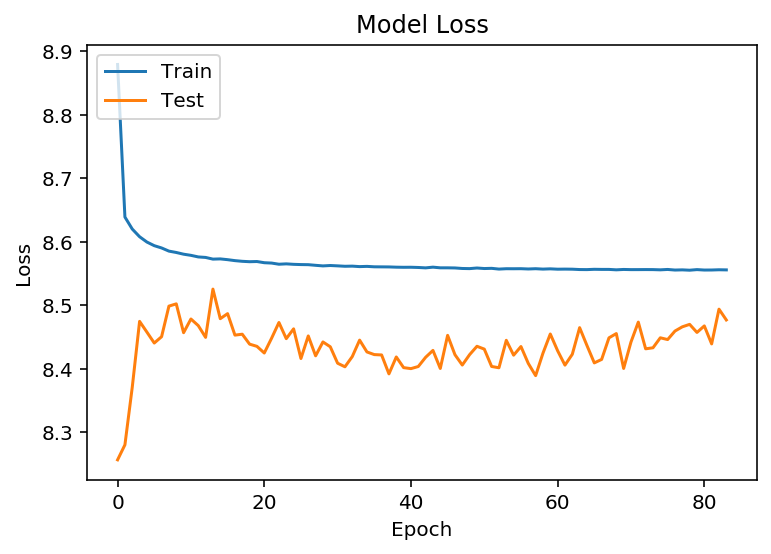

In [22]:
# Train
ops.reset_default_graph()
model_exp_3, attn_exp_3 = create_gru_network(n_notes, n_durations, key_note_emb)
exp_3 = train_network(model_exp_3, 'exp_3', seq_set_4)
plot_loss(exp_3)

In [23]:
# Evaluate
model_exp_3.load_weights('storage/experiments/exp_3/weights.h5')
exp_3_loss = evaluate_loss(model_exp_3, 'exp_3', seq_set_4)
exp_3_loss

1668/1668 [==============================] - 0s 176us/sample - loss: 8.4698 - pitch_loss: 7.3017 - duration_loss: 1.1770


,Set,Loss,Pitch Loss,Duration Loss
0,Train,8.5535,6.9567,1.5966
1,Test,8.4698,7.3017,1.1770


In [24]:
# Generate
exp_3_output = generate_notes(model_exp_3, attn_exp_3, 
                              notes_temp, duration_temp, max_extra_notes, max_seq_len, seq_len, 
                              note_to_int, int_to_note, duration_to_int, int_to_duration)

store_generated_midi(exp_3_output, 'exp_3')

Generated sequence of 64 notes


<br> 

#### Experiment 4: GRU and 12 Sequences

Training over 84 epochs.

84 epochs completed in 242.0 seconds.



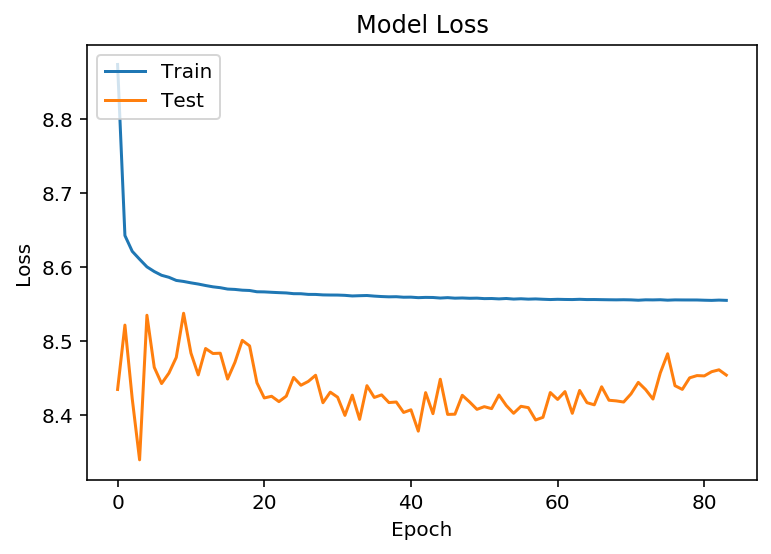

In [25]:
# Train
ops.reset_default_graph()
model_exp_4, attn_exp_4 = create_gru_network(n_notes, n_durations, key_note_emb)
exp_4 = train_network(model_exp_4, 'exp_4', seq_set_12)
plot_loss(exp_4)

In [26]:
# Evaluate
model_exp_4.load_weights('storage/experiments/exp_4/weights.h5')
exp_4_loss = evaluate_loss(model_exp_4, 'exp_4', seq_set_12)
exp_4_loss

1668/1668 [==============================] - 1s 323us/sample - loss: 8.4585 - pitch_loss: 7.3206 - duration_loss: 1.1478


,Set,Loss,Pitch Loss,Duration Loss
0,Train,8.5512,6.9567,1.5944
1,Test,8.4585,7.3206,1.1478


In [27]:
# Generate
exp_4_output = generate_notes(model_exp_4, attn_exp_4, 
                              notes_temp, duration_temp, max_extra_notes, max_seq_len, seq_len, 
                              note_to_int, int_to_note, duration_to_int, int_to_duration)

store_generated_midi(exp_4_output, 'exp_4')

Generated sequence of 64 notes


<br> 

#### Experiment 5: GRU with LSTM and 4 Sequences

Training over 84 epochs.

84 epochs completed in 131.0 seconds.



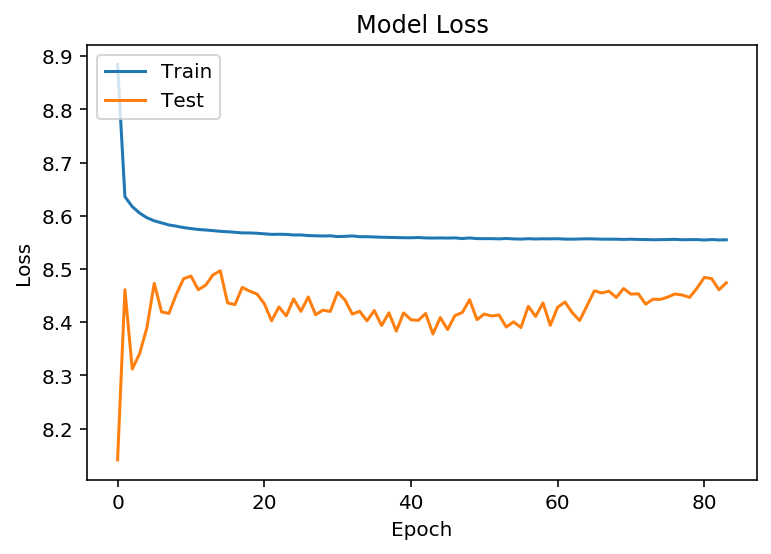

In [28]:
# Train
ops.reset_default_graph()
model_exp_5, attn_exp_5 = create_gru_lstm_network(n_notes, n_durations, key_note_emb)
exp_5 = train_network(model_exp_5, 'exp_5', seq_set_4)
plot_loss(exp_5)

In [29]:
# Evaluate
model_exp_5.load_weights('storage/experiments/exp_5/weights.h5')
exp_5_loss = evaluate_loss(model_exp_5, 'exp_5', seq_set_4)
exp_5_loss

1668/1668 [==============================] - 0s 173us/sample - loss: 8.4842 - pitch_loss: 7.3114 - duration_loss: 1.1813


,Set,Loss,Pitch Loss,Duration Loss
0,Train,8.5536,6.9567,1.5968
1,Test,8.4842,7.3114,1.1813


In [30]:
# Generate
exp_5_output = generate_notes(model_exp_5, attn_exp_5, 
                              notes_temp, duration_temp, max_extra_notes, max_seq_len, seq_len, 
                              note_to_int, int_to_note, duration_to_int, int_to_duration)

store_generated_midi(exp_5_output, 'exp_5')

Generated sequence of 64 notes


<br> 

#### Experiment 6: GRU with LSTM and 12 Sequences

Training over 84 epochs.

84 epochs completed in 228.0 seconds.



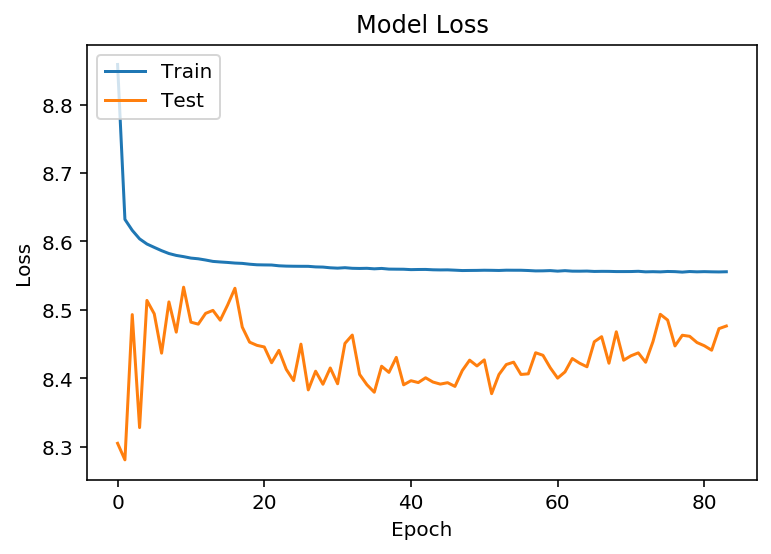

In [31]:
# Train
ops.reset_default_graph()
model_exp_6, attn_exp_6 = create_gru_lstm_network(n_notes, n_durations, key_note_emb)
exp_6 = train_network(model_exp_6, 'exp_6', seq_set_12)
plot_loss(exp_6)

In [32]:
# Evaluate
model_exp_6.load_weights('storage/experiments/exp_6/weights.h5')
exp_6_loss = evaluate_loss(model_exp_6, 'exp_6', seq_set_12)
exp_6_loss

1668/1668 [==============================] - 1s 313us/sample - loss: 8.4630 - pitch_loss: 7.2933 - duration_loss: 1.1787


,Set,Loss,Pitch Loss,Duration Loss
0,Train,8.5526,6.9562,1.5962
1,Test,8.4630,7.2933,1.1787


In [33]:
# Generate
exp_6_output = generate_notes(model_exp_6, attn_exp_6, 
                              notes_temp, duration_temp, max_extra_notes, max_seq_len, seq_len, 
                              note_to_int, int_to_note, duration_to_int, int_to_duration)

store_generated_midi(exp_6_output, 'exp_6')

Generated sequence of 64 notes


<br> 

## Evaluate Models

In [34]:
exp_1_loss['Experiment'] = 1
exp_2_loss['Experiment'] = 2
exp_3_loss['Experiment'] = 3
exp_4_loss['Experiment'] = 4
exp_5_loss['Experiment'] = 5
exp_6_loss['Experiment'] = 6


exp_loss = pd.concat([exp_1_loss, exp_2_loss, exp_3_loss, 
                      exp_4_loss, exp_5_loss, exp_6_loss], axis=0) \
    .reset_index(drop=True)[['Experiment', 'Set', 'Loss', 'Pitch Loss', 'Duration Loss']]

exp_loss.to_csv('storage/outputs/loss_metrics/all_exp_train_val_loss.csv', index=False)

exp_loss


,Experiment,Set,Loss,Pitch Loss,Duration Loss
0,1,Train,8.5552,6.9606,1.5945
1,1,Test,8.4473,7.3306,1.1265
2,2,Train,8.5508,6.9560,1.5947
3,2,Test,8.4736,7.3176,1.1651
4,3,Train,8.5535,6.9567,1.5966
5,3,Test,8.4698,7.3017,1.1770
6,4,Train,8.5512,6.9567,1.5944
7,4,Test,8.4585,7.3206,1.1478
8,5,Train,8.5536,6.9567,1.5968
9,5,Test,8.4842,7.3114,1.1813
